In [1]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from sklearn import ensemble
%matplotlib inline
from collections import Counter
import sklearn.cross_validation
import math

In [2]:
ls

Housing Price Model.ipynb     Running APM on Data.ipynb     xgboost/
Housing Price Modeling.ipynb  Wikipedia n-grams.ipynb
Memoizer.ipynb                data_sci_snippet.csv.zip


In [3]:
filename = "data_sci_snippet.csv.zip"
zf = zipfile.ZipFile(filename, 'r')
print zf.namelist()

['data_sci_snippet.csv']


In [4]:
data = pd.read_csv(zf.open('data_sci_snippet.csv'))

# Convert categorical variables to floats for modeling
data['PoolFloat'] = pd.Series(data['Pool'], dtype ='category').cat.rename_categories(range(len(Counter(data['Pool']))))
data['ListingStatusFloat'] = pd.Series(data['ListingStatus'], dtype ='category').cat.rename_categories(range(len(Counter(data['ListingStatus']))))
data['DwellingTypeFloat'] = pd.Series(data['DwellingType'], dtype ='category').cat.rename_categories(range(len(Counter(data['DwellingType']))))

# Remove Outliers
data = data[(data['ClosePrice'] != 1)]
data = data[(data['ListPrice'] <= 7000000)]

print data.shape
data[:5]

(57237, 18)


,ListingId,LivingArea,NumBedrooms,NumBaths,Pool,ExteriorStories,ListDate,ListPrice,GeoLat,GeoLon,PublicRemarks,CloseDate,ClosePrice,ListingStatus,DwellingType,PoolFloat,ListingStatusFloat,DwellingTypeFloat
0,5077399,3054,4,2.5,Private,1,2014-03-04,675000,33.593239,-111.961056,This property OUTSTANDING offers outdoor livin...,NaN,NaN,Cancelled,Single Family - Detached,3,1,6
1,5077408,2230,4,2.0,Private,1,2014-03-01,475000,33.650984,-111.963151,Very special home in popular Arabian Views fee...,2014-06-24,460000,Closed,Single Family - Detached,3,2,6
2,5077486,1601,3,2.0,Private,1,2014-03-01,279900,33.692122,-112.038019,Welcome home to a beautiful remodeled. Single ...,2014-07-15,279900,Closed,Single Family - Detached,3,2,6
3,5077487,2440,4,2.5,None,2,2014-03-01,229900,33.647270,-112.251490,"NO HOA!! MOVE-IN READY!! Location, Condition ...",2014-05-28,228000,Closed,Single Family - Detached,2,2,6
4,5077489,3980,5,3.0,None,1,2014-03-01,385250,33.389139,-111.712757,Price reduced to under $100 per square foot! F...,2014-08-20,385250,Closed,Single Family - Detached,2,2,6


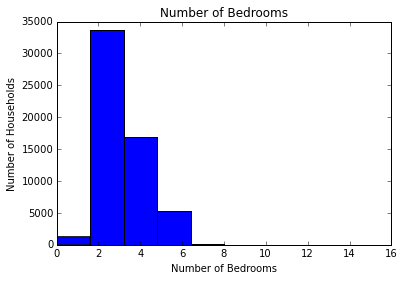

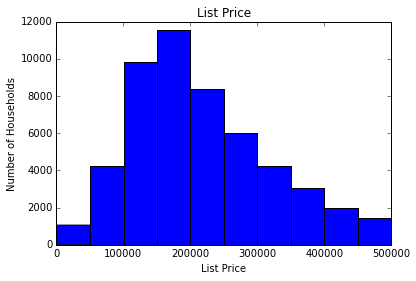

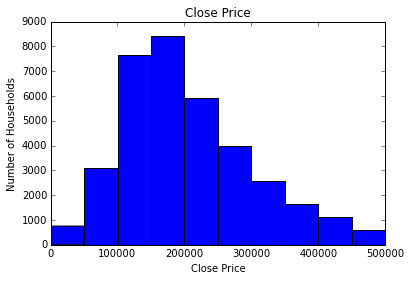

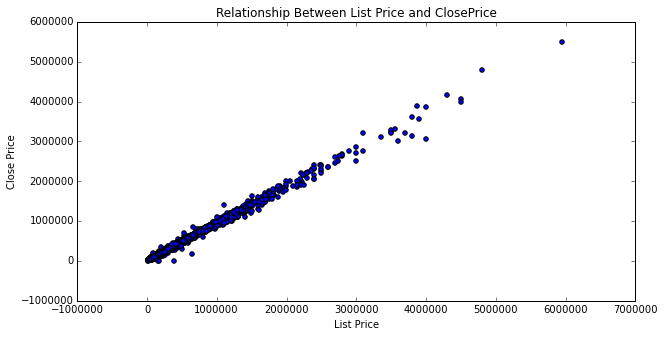

In [5]:
# Visualize Important Variables

plt.hist(data['NumBedrooms'])
plt.title('Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Number of Households')
plt.show()


for_price_visualization = data[(data['ListPrice'] < 500000)]
plt.hist(np.array(for_price_visualization['ListPrice']))
plt.title('List Price')
plt.xlabel('List Price')
plt.ylabel('Number of Households')
plt.show()

for_close_price_visualization = data[(data['ClosePrice'] < 500000)]
plt.hist(np.array(for_close_price_visualization['ClosePrice'].dropna()))
plt.title('Close Price')
plt.xlabel('Close Price')
plt.ylabel('Number of Households')
plt.show()

plt.figure(figsize=(10,5))
plt.scatter(data['ListPrice'], data['ClosePrice'])
plt.title('Relationship Between List Price and ClosePrice')
plt.xlabel('List Price')
plt.ylabel('Close Price')
plt.show()

In [6]:
# Look at linear relationship strength
data.corr()

,ListingId,LivingArea,NumBedrooms,NumBaths,ExteriorStories,ListPrice,GeoLat,GeoLon,ClosePrice
ListingId,1.000000,-0.020191,0.005310,-0.008613,-0.003899,-0.022915,-0.003010,-0.003203,-0.029109
LivingArea,-0.020191,1.000000,0.684533,0.121022,0.078552,0.732399,0.038962,0.021504,0.731471
NumBedrooms,0.005310,0.684533,1.000000,0.093270,0.016524,0.342287,-0.081432,-0.001445,0.360630
NumBaths,-0.008613,0.121022,0.093270,1.000000,0.018845,0.095709,0.008440,0.002334,0.067489
ExteriorStories,-0.003899,0.078552,0.016524,0.018845,1.000000,0.034321,0.002526,0.014489,0.022120
ListPrice,-0.022915,0.732399,0.342287,0.095709,0.034321,1.000000,0.137890,0.070848,0.997483
GeoLat,-0.003010,0.038962,-0.081432,0.008440,0.002526,0.137890,1.000000,-0.269421,0.132558
GeoLon,-0.003203,0.021504,-0.001445,0.002334,0.014489,0.070848,-0.269421,1.000000,0.097644
ClosePrice,-0.029109,0.731471,0.360630,0.067489,0.022120,0.997483,0.132558,0.097644,1.000000


In [7]:
without_na = data.dropna()
print without_na.shape

(37506, 18)


In [8]:
# Split Training and Testing Data
x = without_na.drop(['Pool', 'ListDate', 'PublicRemarks', 'ClosePrice', 'CloseDate', 'ListingStatus', 'DwellingType'], axis=1)
y = without_na['ClosePrice']


x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    x, y, test_size=0.20, random_state=42)

print x_train.shape
print x_test.shape
print y_train.shape
print y_test.shape

(30004, 11)
(7502, 11)
(30004,)
(7502,)


In [9]:
train = x[:30004]
test = x[30004:]

In [10]:
train_x = train[['NumBedrooms', 'NumBaths','ListPrice']]
train_x['Target'] = y
print train_x[:5]
print train_y[:5]

   NumBedrooms  NumBaths  ListPrice  Target
1            4       2.0     475000  460000
2            3       2.0     279900  279900
3            4       2.5     229900  228000
4            5       3.0     385250  385250
5            3       2.0     155000  159000


/Users/jeremynixon/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


NameError: name 'train_y' is not defined

In [ ]:
price = test[7:8]['ListPrice']
distance = []
for i in np.array(train_x['ListPrice']):
    distance.append(float(abs(price - i)))
train_x['Distance'] = distance
train_x = train_x.sort('Distance')

k=10
count = 0
for i in range(k):
    count += float(train_x[i:i+1]['Target'])
    result = count/k
print result


In [ ]:
test[:10]

In [ ]:
k=10
count = 0
for i in range(k):
    count += float(train_x[i:i+1]['Target'])
    result = count/k
print result

In [ ]:
distance = []
for i in np.array(train_x['ListPrice']):
    distance.append(abs(np.array(test[5:6]['ListPrice']) - i))

In [288]:
distance[:5]

[array([ 50000.]),
 array([ 50000.]),
 array([ 50000.]),
 array([ 50000.]),
 array([ 50000.])]

In [11]:
clf = ensemble.RandomForestRegressor(n_estimators = 1000)
clf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [12]:
predictions = clf.predict(x_test)

In [13]:
# Root Mean Squared Error
def RMSE(predictions, actual):
    squared_error = (predictions - actual)**2
    MSE = squared_error.mean()
    RMSE = math.sqrt(MSE)
    return RMSE

In [14]:
print RMSE(y_test, predictions)

15659.2192544


In [15]:
# Mean Absolute Error
def MAE(predictions, actual):
    MAE = (abs(predictions-y_test).mean())
    return MAE

In [16]:
MAE(predictions, y_test)

6671.2038397760598

In [17]:
1-((abs(predictions-y_test).mean())/y_test.mean())

0.97243259548113348

In [18]:
# Cross Validated Model Evaluation
forest = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
scores = sklearn.cross_validation.cross_val_score(forest, x, y, cv=10)
print np.mean(scores), np.std(scores)

0.99387719013 0.00117482461797


In [19]:
R2 = pd.Series(predictions).corr(pd.Series(y_test))**2
R2

0.0070846883727494698

In [21]:
print np.median(abs(predictions-y_test))

3859.2885


In [327]:
points = without_na[['ListPrice','ClosePrice']]

In [336]:
points[:2]

,ListPrice,ClosePrice
1,475000,460000
2,279900,279900


In [347]:
X = array(points)
X = array([[1] + list(p[:-1]) for p in X])
X

array([[  1.00000000e+00,   4.75000000e+05],
       [  1.00000000e+00,   2.79900000e+05],
       [  1.00000000e+00,   2.29900000e+05],
       ..., 
       [  1.00000000e+00,   1.10000000e+05],
       [  1.00000000e+00,   8.50000000e+04],
       [  1.00000000e+00,   9.50000000e+04]])

In [355]:
X = array(points)
X = array([[1] + list(p[:-1]) for p in X])
y = array([p[-1] for p in X])
d = dot(transpose(X),X).shape
d

(2, 2)

In [358]:
from numpy import array, dot, transpose
from numpy.linalg import inv

def linear_regression(points):
    X = array(points)
    X = array([[1] + list(p[:-1]) for p in X])
    y = array([p[-1] for p in X])
    
    #print X
    #print y
    
    Xt = transpose(X)
    theInverse = inv(dot(Xt, X))
    w = dot(dot(theInverse, Xt), y)
    return w, lambda x: dot(w,x)
linear_regression(points)

(array([ -2.03272066e-10,   1.00000000e+00]), <function __main__.<lambda>>)

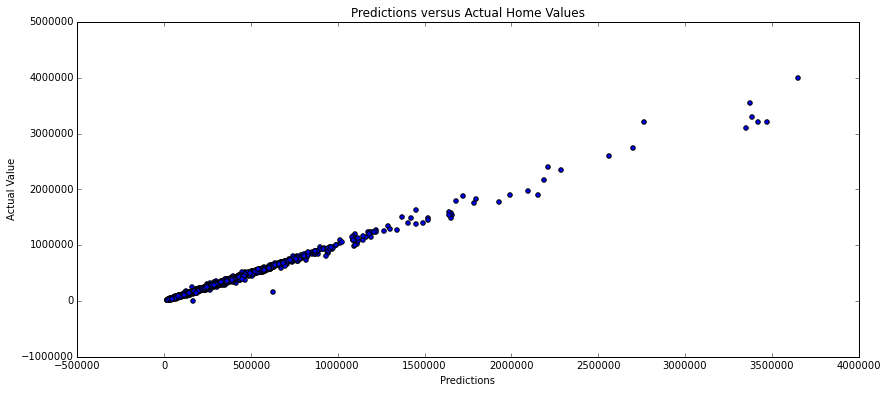

In [298]:
# Visualize Predictions

plt.figure(figsize = (14, 6))
plt.scatter(predictions, y_test)
plt.title('Predictions versus Actual Home Values')
plt.xlabel('Predictions')
plt.ylabel('Actual Value')

In [299]:
# Split Training and Testing Data, This Time Without List Price
x = without_na.drop(['Pool', 'ListDate', 'ListPrice', 'PublicRemarks', 'ClosePrice', 'CloseDate', 'ListingStatus', 'DwellingType'], axis=1)
y = without_na['ClosePrice']


x_train, x_test, y_train, y_test = sklearn.cross_validation.train_test_split(
    x, y, test_size=0.20, random_state=42)

print x_train.shape
print x_test.shape
print y_train.shape
print y_test.shape

(30004, 10)
(7502, 10)
(30004,)
(7502,)


In [300]:
clf = ensemble.RandomForestRegressor(n_estimators = 100)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

In [301]:
# Root Mean Squared Error
def RMSE(predictions, actual):
    squared_error = (predictions - actual)**2
    MSE = squared_error.mean()
    RMSE = math.sqrt(MSE)
    return RMSE
print RMSE(y_test, predictions)

76750.4993297


In [302]:
# Mean Absolute Error
def MAE(predictions, actual):
    MAE = (abs(predictions-y_test).mean())
    return MAE
MAE(predictions, y_test)

32994.679072247403

In [303]:
1-((abs(predictions-y_test).mean())/y_test.mean())

0.86365614260928403

In [304]:
# Cross Validated Model Evaluation Without List Price
forest = sklearn.ensemble.RandomForestRegressor(n_estimators=10)
scores = sklearn.cross_validation.cross_val_score(forest, x, y, cv=10)
print np.mean(scores), np.std(scores)

0.846276860794 0.0199454783352


In [305]:
R2 = pd.Series(predictions).corr(pd.Series(y_test))**2
R2

0.85801438276087194

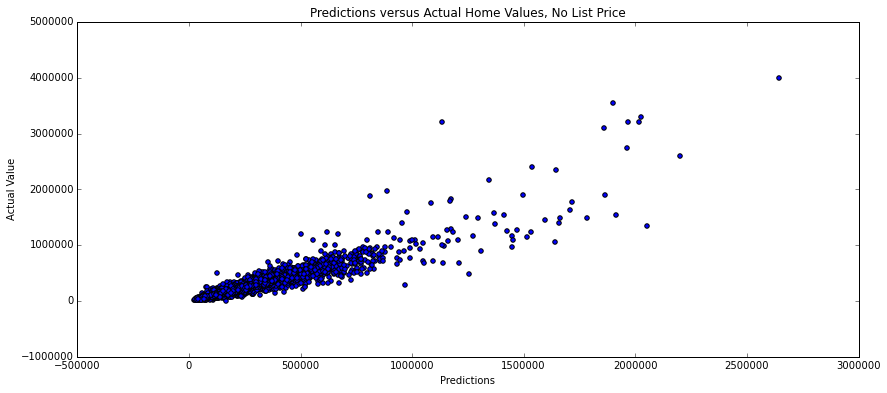

In [306]:
# Visualize Predictions

plt.figure(figsize = (14, 6))
plt.scatter(predictions, y_test)
plt.title('Predictions versus Actual Home Values, No List Price')
plt.xlabel('Predictions')
plt.ylabel('Actual Value')

In [317]:
clf = ensemble.GradientBoostingRegressor(n_estimators=10000)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

In [322]:
def RMSE(predictions, actual):
    squared_error = (predictions - actual)**2
    MSE = squared_error.mean()
    RMSE = math.sqrt(MSE)
    return RMSE
print RMSE(y_test, predictions)

77284.9112541


In [323]:
# Mean Absolute Error
def MAE(predictions, actual):
    MAE = (abs(predictions-y_test).mean())
    return MAE
MAE(predictions, y_test)

35102.358924218526

In [324]:
1-((abs(predictions-y_test).mean())/y_test.mean())

0.85494658066648732

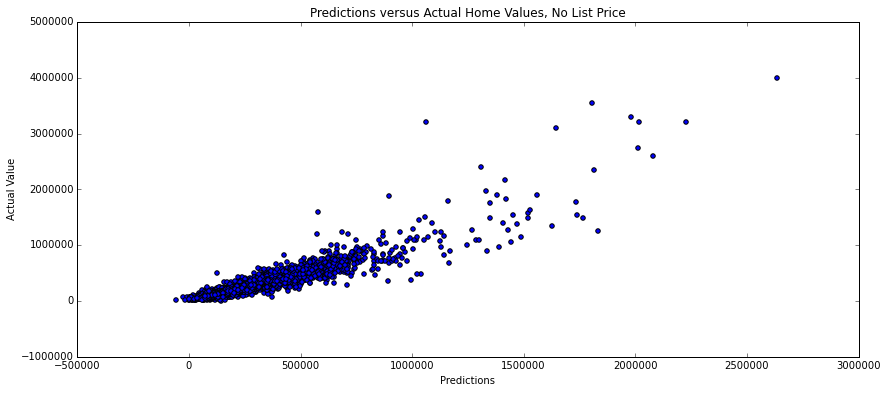

In [325]:
# Visualize Predictions

plt.figure(figsize = (14, 6))
plt.scatter(predictions, y_test)
plt.title('Predictions versus Actual Home Values, No List Price')
plt.xlabel('Predictions')
plt.ylabel('Actual Value')

In [359]:
importance_list = clf.feature_importances_
name_list = df.columns
importance_list, name_list = zip(*sorted(zip(importance_list, name_list)))
plt.barh(range(len(name_list)),importance_list,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

TypeError: 'DataFrame' object is not callable

AssertionError: incompatible sizes: argument 'height' must be length 18 or scalar

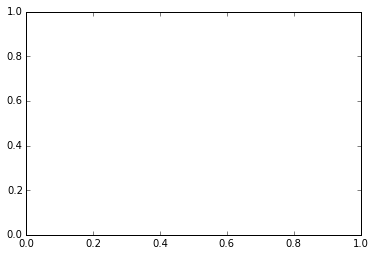

In [366]:
plt.bar(name_list, importance_list)

ImportError: No module named linear_regression